<a href="https://colab.research.google.com/github/glenamac/TensorFlowHurstExponent/blob/main/TensorFlowHurstExponent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Neural Network to Recognize Hurst Exponents from Fractal Brownian Motion



## Imports and Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


## Load data from Google Drive

In [3]:
input=np.array(pd.read_csv("drive/My Drive/FractalBrownianMotion/input3.dat",header=None))

## Reshape Data

Fractal Brownian motion light curves are generated using [MATLAB](https://www.mathworks.com/help/wavelet/ref/wfbm.html). Portable Network Graphic (.png) images are created and saved in 640x480 resolution using [Gnuplot](http://www.gnuplot.info/) and then converted into grayscale raw datafiles using [Numpy](https://numpy.org) and [OpenCV](https://opencv.org/). 

The image data created in Gnuplot are connected with lines connecting points and no symbol markers being used for points but testing to what degree using lines or not, using point symbols or not, symbol type, etc, matters should be done.  

The raw data are in single-column, plain ascii files. The reason for this formt is that Python/Pandas is optimized to load many rows of data but only for small numbers of columns. 

NOTE: Despite appearances, the constant 307201 is not a magic number ... it is 640*480, or the number of pixels in the .png graphics being used plus one column for labels. 

One reason to reshape the data, but perhaps not a great one, is that the labels for each light curve are stored as a single integer at the end of the each 307201 length light curve. The first is at 307201, the second is at 614402, and so on. By reshaping the data into a rectangle of width 307201, the labels all appear in the last column and are trivial to slice thru. Of course, the rectangular data, with the labels removed are once again flattened before passing them onto the internal layers of the model. See below. 

In [4]:
num_pixels_and_label = 640*480+1

In [5]:
numrows=int(input.shape[0]/num_pixels_and_label)

At this point, every row in reshaped_input (numrows) represents a light curve

In [6]:
reshaped_input=np.reshape(input,[numrows,num_pixels_and_label])


### Recast Data as Integer Type

In [7]:
data = np.array(reshaped_input,dtype="int")


## Shuffle The Data

We want to surprise the model so as not to see many of the same types of light curves grouped together. 

In [8]:
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets
data.shape

(900, 307201)

Slice out the last column where the labels are stored and add them to ```train_labels```.



In [9]:
train_labels=data[:,-1]
#train_labels

Add the remainder of the data (the actual pixel data) to ```train_images``` and confirm the shape. 

In [10]:
train_images=np.reshape(data[:,0:n-1],[numrows,480,640])
(j,k,l)=train_images.shape
j,k,l

(900, 480, 640)

## Print some example light curves as a quick sanity check.

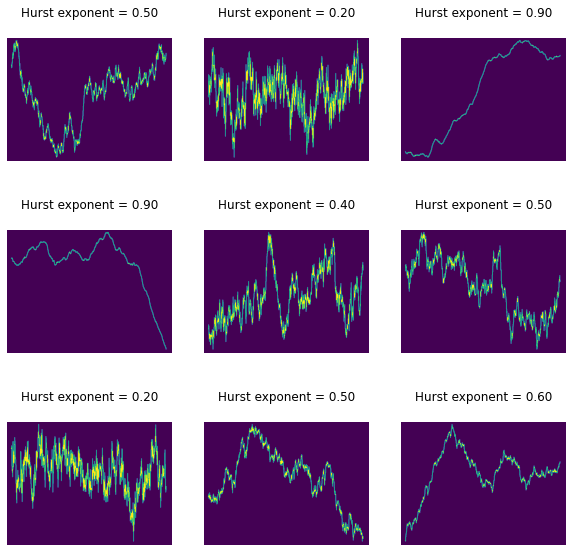

In [11]:
Index=0
plt.figure(figsize=(10, 10))
for Index in range(9):
    ax = plt.subplot(3, 3, Index + 1)
    plt.imshow(train_images[Index])
    plt.title("Hurst exponent = %0.2f\n" % (data[Index,-1]/10.))
    plt.axis("off")

### Clean up unneeded objects in case memory starts getting scarce.

In [12]:
#del(input)
#del(dev)
#del(reshaped_input)
#del(data)

## Create and compile model



Can make changes to the model like the number of layers, the number of neurons per layer, the activation function. 

In [13]:
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape=(480, 640)),
                             tf.keras.layers.Dense(128,activation="relu"),
                             tf.keras.layers.Dense(10)

])

In [14]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"]
              )

## Train the model



### Generally seeing nearly 100% accuracy in fewer than 10 epochs.

In [15]:
model.fit(train_images,train_labels,epochs=5)

Epoch 1/5
29/29 [==============================] - 9s 294ms/step - loss: 7.6830 - accuracy: 0.1911
Epoch 2/5
29/29 [==============================] - 8s 291ms/step - loss: 1.1764 - accuracy: 0.6856
Epoch 3/5
29/29 [==============================] - 8s 292ms/step - loss: 0.2932 - accuracy: 0.9211
Epoch 4/5
29/29 [==============================] - 8s 289ms/step - loss: 0.1096 - accuracy: 0.9733
Epoch 5/5
29/29 [==============================] - 8s 285ms/step - loss: 0.0379 - accuracy: 0.9967


Show user model summary; num. of layers, shape, num. of parameters.

In [16]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 307200)            0         
                                                                 
 dense (Dense)               (None, 128)               39321728  
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 39,323,018
Trainable params: 39,323,018
Non-trainable params: 0
_________________________________________________________________
